In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS =50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "photos",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)  #68*32batch_size=2176 nearly 2152 -> simply number of data in one batch

68

In [6]:
for image_batch,label_batch in dataset.take(1): #give only one batch
    print(image_batch.shape)
    print(label_batch.numpy()) #every element we get is a tensor therefore we want to covert it to numpy 

(32, 256, 256, 3)
[1 1 1 2 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 2 1 1 0 0 1 2 1 2 1]


In [7]:
for image_batch,label_batch in dataset.take(1): #give only one batch
    #print(image_batch)
    print(image_batch.numpy())

[[[[192. 195. 204.]
   [193. 196. 205.]
   [194. 197. 206.]
   ...
   [168. 169. 187.]
   [170. 171. 189.]
   [171. 172. 190.]]

  [[185. 188. 197.]
   [188. 191. 200.]
   [190. 193. 202.]
   ...
   [168. 169. 187.]
   [168. 169. 187.]
   [169. 170. 188.]]

  [[178. 181. 190.]
   [182. 185. 194.]
   [185. 188. 197.]
   ...
   [168. 169. 187.]
   [168. 169. 187.]
   [168. 169. 187.]]

  ...

  [[137. 139. 151.]
   [137. 139. 151.]
   [135. 137. 149.]
   ...
   [118. 121. 138.]
   [116. 119. 136.]
   [115. 118. 135.]]

  [[127. 129. 141.]
   [127. 129. 141.]
   [134. 136. 148.]
   ...
   [114. 117. 134.]
   [114. 117. 134.]
   [113. 116. 133.]]

  [[143. 145. 157.]
   [134. 136. 148.]
   [132. 134. 146.]
   ...
   [120. 123. 140.]
   [118. 121. 138.]
   [118. 121. 138.]]]


 [[[191. 190. 198.]
   [189. 188. 196.]
   [186. 185. 193.]
   ...
   [170. 168. 181.]
   [171. 169. 182.]
   [173. 171. 184.]]

  [[190. 189. 197.]
   [189. 188. 196.]
   [187. 186. 194.]
   ...
   [170. 168. 181.]
 

In [8]:
print(image_batch[0].shape)

(256, 256, 3)


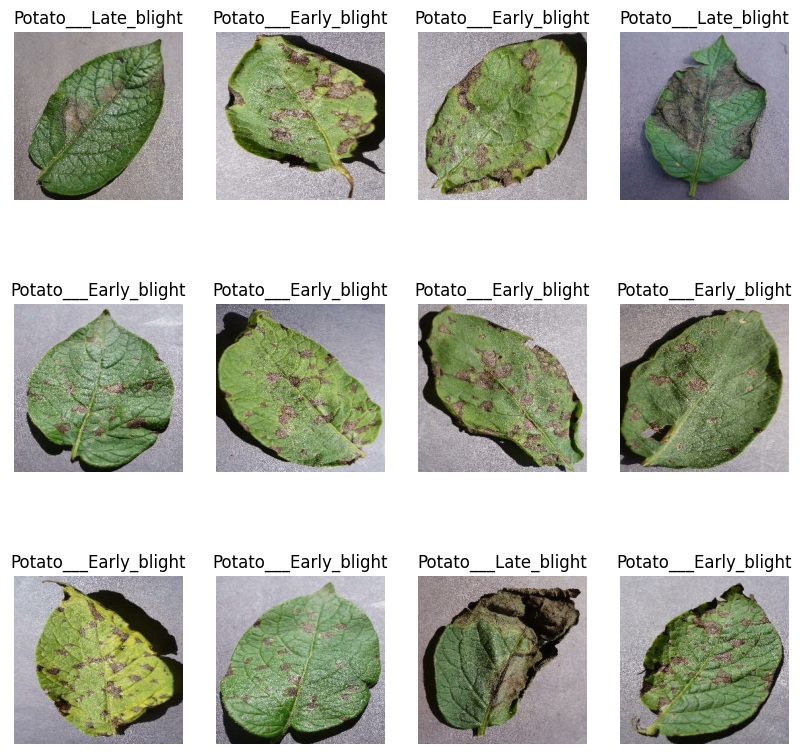

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1): #give only one batch
    for i in range(12):
        a = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
len(dataset)

68

In [11]:
#80% training
#20% => 10% validation 10% testing
train_size =0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54) #arr(:54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54) #arr(54:)
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds =test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [18]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),  #resize the image to 256*256 (if there is different type image it resize to this value)
    layers.Rescaling(1.0/255), #rescale the pixel values to the range [0, 1].
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), #flipping should occur both horizontally and vertically.
    layers.RandomRotation(0.2) #images will be rotated by a random angle in the range of -20% to 20% of a full circle
])

In [25]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape = input_shape)

C:\Users\sudee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 466ms/step - accuracy: 0.4428 - loss: 0.9410 - val_accuracy: 0.6354 - val_loss: 0.8648
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 429ms/step - accuracy: 0.6696 - loss: 0.7560 - val_accuracy: 0.7344 - val_loss: 0.5640
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 434ms/step - accuracy: 0.7836 - loss: 0.4827 - val_accuracy: 0.8125 - val_loss: 0.5633
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 417ms/step - accuracy: 0.8702 - loss: 0.3152 - val_accuracy: 0.9115 - val_loss: 0.1839
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 421ms/step - accuracy: 0.9093 - loss: 0.2316 - val_accuracy: 0.9010 - val_loss: 0.2246
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 420ms/step - accuracy: 0.9117 - loss: 0.2285 - val_accuracy: 0.9427 - val_loss: 0.1747
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 432ms/step - accuracy: 0.9259 - loss: 0.1871 - val_accuracy: 0.9531 - val_loss: 0.1450
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 444ms/step - accuracy: 0.9281 - loss: 0.1908 - val_accu

In [29]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.9960 - loss: 0.0120


In [30]:
scores

[0.017760617658495903, 0.9921875]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
history.history['accuracy']

[0.49942129850387573,
 0.6649305820465088,
 0.8206018805503845,
 0.8894675970077515,
 0.9056712985038757,
 0.921875,
 0.9224537014961243,
 0.9392361044883728,
 0.9346064925193787,
 0.9380787014961243,
 0.9565972089767456,
 0.9467592835426331,
 0.9513888955116272,
 0.9571759104728699,
 0.9456018805503845,
 0.9629629850387573,
 0.9560185074806213,
 0.9670138955116272,
 0.9606481194496155,
 0.96875,
 0.9641203880310059,
 0.9681712985038757,
 0.9652777910232544,
 0.9832175970077515,
 0.9670138955116272,
 0.9751157164573669,
 0.9745370149612427,
 0.9809027910232544,
 0.9768518805503845,
 0.9826388955116272,
 0.9577546119689941,
 0.9814814925193787,
 0.9809027910232544,
 0.9809027910232544,
 0.9832175970077515,
 0.9872685074806213,
 0.9895833134651184,
 0.984375,
 0.9866898059844971,
 0.9849537014961243,
 0.9901620149612427,
 0.9872685074806213,
 0.9924768805503845,
 0.9918981194496155,
 0.9924768805503845,
 0.9884259104728699,
 0.9814814925193787,
 0.9809027910232544,
 0.9930555820465088,
 

In [35]:
len(history.history['accuracy'])

50

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

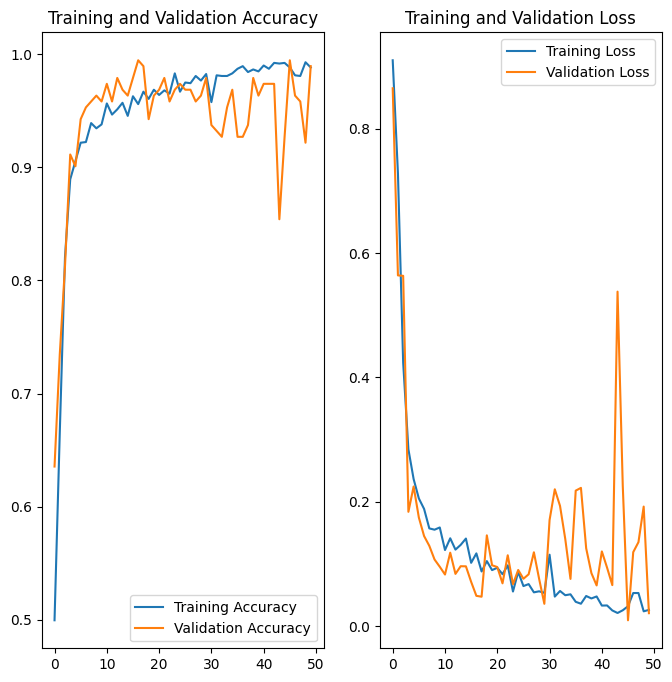

In [37]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label :  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
predicted label : Potato___Late_blight


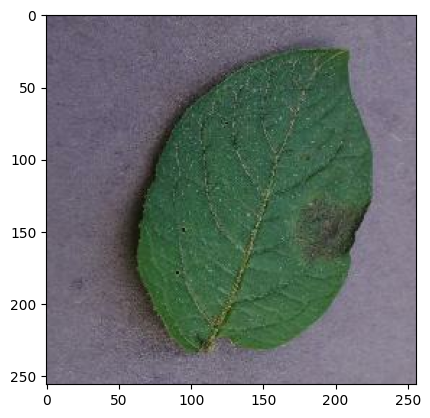

In [38]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label : ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label :" , class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


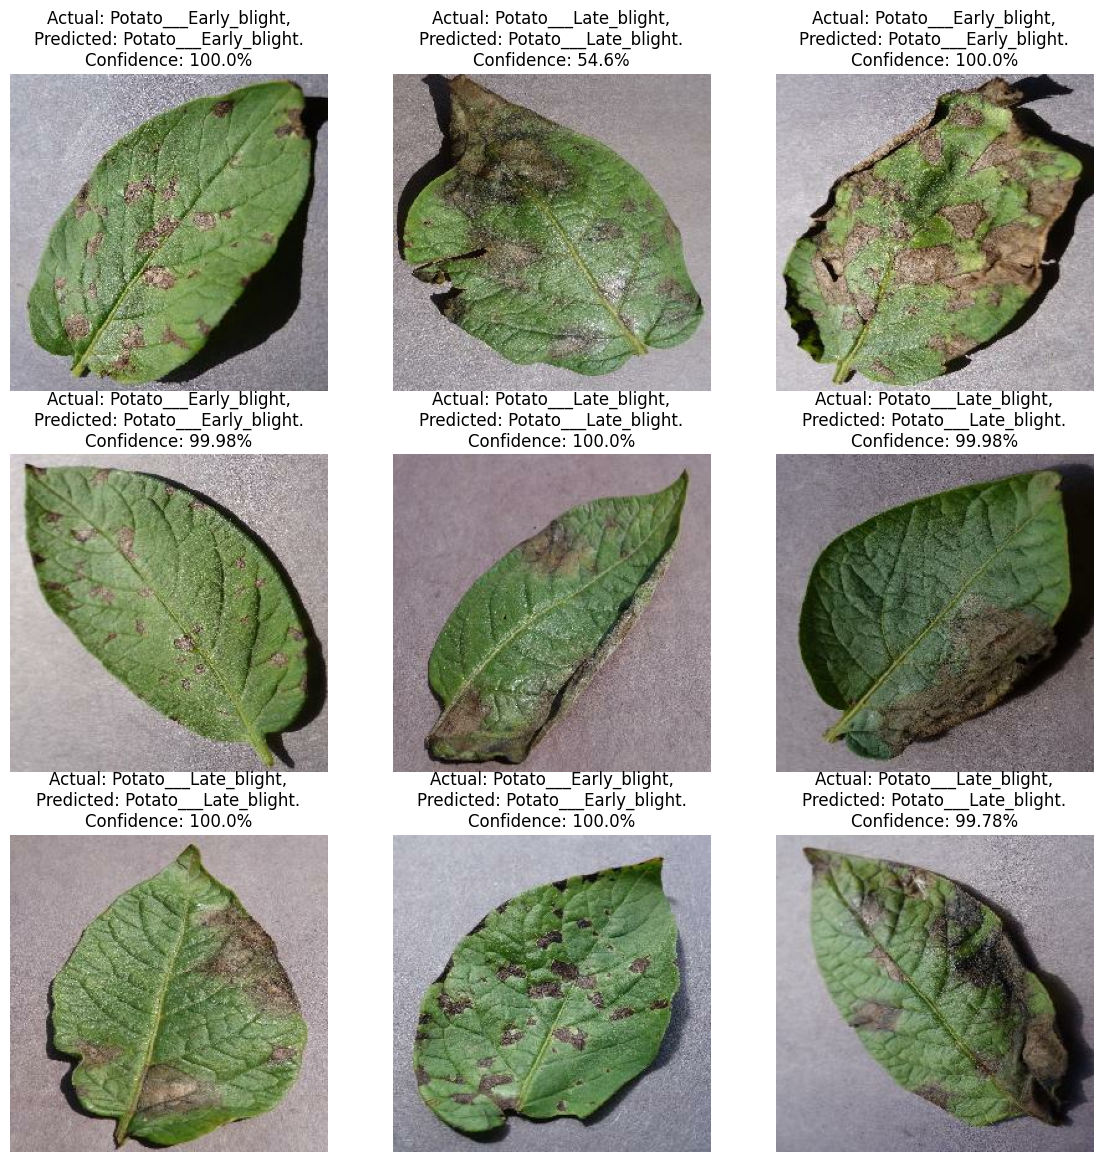

In [40]:
plt.figure(figsize=(14, 14))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        
        plt.axis("off")

In [66]:
import os
import re

# Directory containing the models
model_dir = "../Model"

# Get the list of files in the directory
files = os.listdir(model_dir)

# Define a regular expression pattern to match filenames like 'model_v1.keras'
pattern = re.compile(r'model_v(\d+)\.keras')

# Extract numeric parts and convert to integers
model_versions = [int(pattern.match(file).group(1)) for file in files if pattern.match(file)]

# Find the maximum version number and increment it
model_version = max(model_versions, default=0) + 1

# Save the model with the new version number
model.save(os.path.join(model_dir, f"model_v{model_version}.keras"))
